Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 1.6853, Validation Loss: 1.3912, Train Accuracy: 0.3891, Validation Accuracy: 0.5071
Epoch 2/50, Train Loss: 1.4111, Validation Loss: 1.2572, Train Accuracy: 0.4912, Validation Accuracy: 0.5556
Epoch 3/50, Train Loss: 1.3001, Validation Loss: 1.1745, Train Accuracy: 0.5336, Validation Accuracy: 0.5768
Epoch 4/50, Train Loss: 1.2256, Validation Loss: 1.1081, Train Accuracy: 0.5613, Validation Accuracy: 0.6046
Epoch 5/50, Train Loss: 1.1590, Validation Loss: 1.0352, Train Accuracy: 0.5861, Validation Accuracy: 0.6354
Epoch 6/50, Train Loss: 1.1071, Validation Loss: 0.9998, Train Accuracy: 0.6045, Validation Accuracy: 0.6484
Epoch 7/50, Train Loss: 1.0674, Validation Loss: 0.9911, Train Accuracy: 0.6220, Validation Accuracy: 0.6529
Epoch 8/50, Train Loss: 1.0286, Validation Loss: 0.9440, Train Accuracy: 0.6364, Validation Accuracy: 0.6713
Epoch 9/50, Train Loss: 0.9982, Validation Loss: 0.9

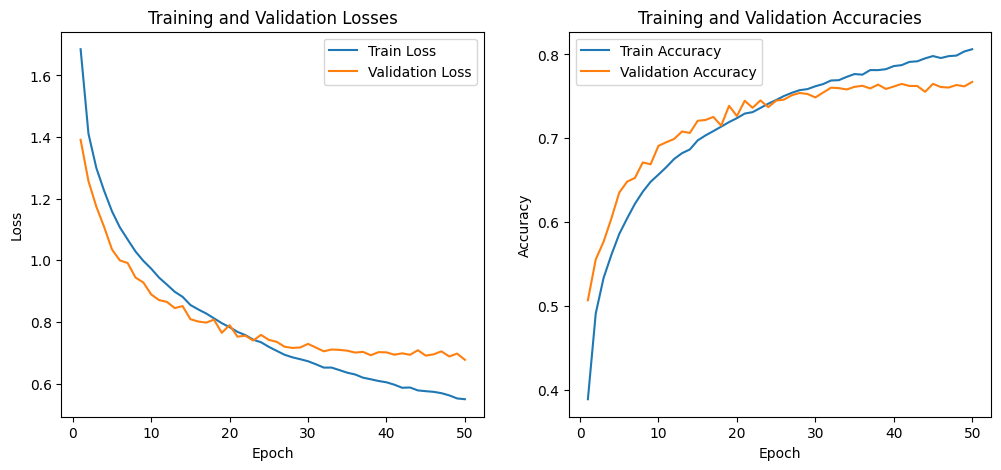

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define custom dataset class
class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels):
        # Normalize the image values to [0, 1] and convert to tensors
        self.x = torch.tensor(images, dtype=torch.float32) / 255.0  # Normalize
        self.x = self.x.permute(0, 3, 1, 2)  # Change shape from (N, 32, 32, 3) to (N, 3, 32, 32) for PyTorch
        self.y = torch.tensor(labels, dtype=torch.long)  # Labels as tensors

    def __len__(self):
        # Return the total number of samples
        return len(self.x)

    def __getitem__(self, idx):
        # Return a single sample
        return self.x[idx], self.y[idx]

# Load CIFAR-10 dataset using torchvision
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomCrop(32, padding=4),  # Random cropping
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))  # Normalization
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
])

# Download and load CIFAR-10
train_cifar10 = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_cifar10 = datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

# Convert to numpy arrays for CIFAR10Dataset
tr_images = train_cifar10.data  # Training images
tr_targets = np.array(train_cifar10.targets)  # Training labels
val_images = test_cifar10.data  # Testing images
val_targets = np.array(test_cifar10.targets)  # Testing labels

# Create CIFAR-10 datasets
train_dataset = CIFAR10Dataset(tr_images, tr_targets)
valid_dataset = CIFAR10Dataset(val_images, val_targets)

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Model Definition
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(n_feature * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)  # 10 classes for CIFAR-10
        # Dropout
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(x.size(0), -1)  # Flatten
        return x

    def classifier(self, x):
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Instantiate model
torch.manual_seed(13)
model = CNN2(n_feature=32, p=0.5).to(device)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training and Validation
def accuracy(outputs, targets):
    _, predictions = torch.max(outputs, 1)
    correct = (predictions == targets).sum().item()
    return correct / targets.size(0)

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

# Training Loop
n_epochs = 50
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = validate(model, valid_dataloader, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.show()


Epoch 1/50, Train Loss: 1.6934, Validation Loss: 1.4710, Train Accuracy: 0.3731, Validation Accuracy: 0.4652
Epoch 2/50, Train Loss: 1.3978, Validation Loss: 1.3411, Train Accuracy: 0.4960, Validation Accuracy: 0.5176
Epoch 3/50, Train Loss: 1.2665, Validation Loss: 1.2734, Train Accuracy: 0.5462, Validation Accuracy: 0.5473
Epoch 4/50, Train Loss: 1.1875, Validation Loss: 1.2283, Train Accuracy: 0.5767, Validation Accuracy: 0.5689
Epoch 5/50, Train Loss: 1.1262, Validation Loss: 1.1782, Train Accuracy: 0.5988, Validation Accuracy: 0.5789
Epoch 6/50, Train Loss: 1.0848, Validation Loss: 1.1286, Train Accuracy: 0.6159, Validation Accuracy: 0.6022
Epoch 7/50, Train Loss: 1.0422, Validation Loss: 1.1271, Train Accuracy: 0.6296, Validation Accuracy: 0.6062
Epoch 8/50, Train Loss: 1.0090, Validation Loss: 1.0865, Train Accuracy: 0.6435, Validation Accuracy: 0.6179
Epoch 9/50, Train Loss: 0.9752, Validation Loss: 1.1158, Train Accuracy: 0.6543, Validation Accuracy: 0.6132
Epoch 10/50, Train 

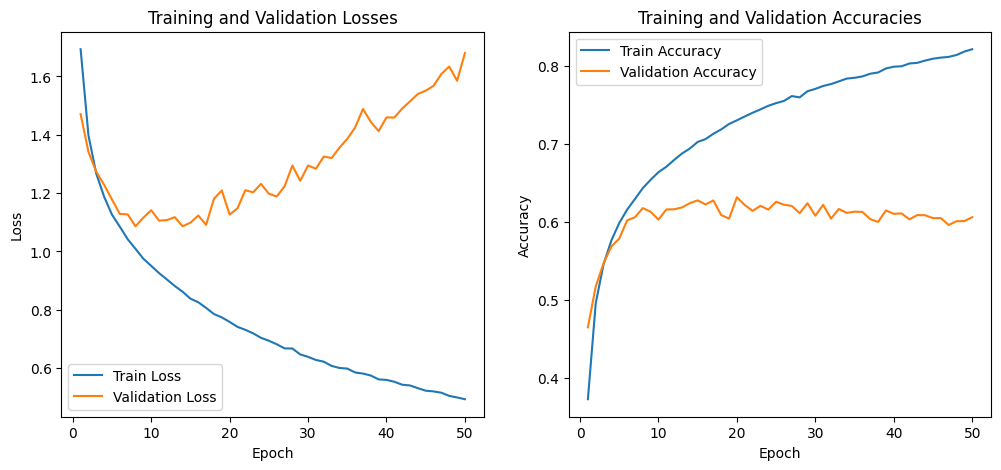

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the LeNet-5 architecture
class Lenet5(nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        # Updated to handle 3 input channels for CIFAR-10
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # Input: (3, 32, 32) -> Output: (6, 28, 28)
        self.pool1 = nn.MaxPool2d(2, 2)             # Output: (6, 14, 14)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Output: (16, 10, 10)
        self.pool2 = nn.MaxPool2d(2, 2)             # Output: (16, 5, 5)
        self.flatten = nn.Flatten()                # Flatten to (16 * 5 * 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)      # Fully connected layer
        self.fc2 = nn.Linear(120, 84)              # Fully connected layer
        self.fc3 = nn.Linear(84, 10)               # Output layer (10 classes)
        self.relu = nn.ReLU()

    def featurize(self, x):  # Extract feature maps
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        return x

    def classifier(self, x):  # Classifier
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

    def forward(self, x):  # Forward pass
        x = self.featurize(x)
        x = self.classifier(x)
        return x


# Define Dataset class for CIFAR-10
class CIFAR10Dataset(Dataset):
    def __init__(self, x, y):
        x = torch.tensor(x, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
        x = x.permute(0, 3, 1, 2)  # Reshape to (N, 3, 32, 32)
        self.x = x
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


# Load CIFAR-10 dataset
train_dataset = CIFAR10Dataset(tr_images, tr_targets)
valid_dataset = CIFAR10Dataset(val_images, val_targets)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Instantiate the model
model = Lenet5().to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training and validation functions
def accuracy(outputs, targets):
    _, predictions = torch.max(outputs, 1)
    correct = (predictions == targets).sum().item()
    return correct / targets.size(0)

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)


# Training loop
n_epochs = 50
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = validate(model, valid_dataloader, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

# Plot losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 1.3995, Validation Loss: 1.2460, Train Accuracy: 0.4925, Validation Accuracy: 0.5658
Epoch 2/50, Train Loss: 1.0694, Validation Loss: 0.9349, Train Accuracy: 0.6216, Validation Accuracy: 0.6755
Epoch 3/50, Train Loss: 0.9575, Validation Loss: 0.8116, Train Accuracy: 0.6672, Validation Accuracy: 0.7152
Epoch 4/50, Train Loss: 0.8825, Validation Loss: 0.7674, Train Accuracy: 0.6940, Validation Accuracy: 0.7290
Epoch 5/50, Train Loss: 0.8256, Validation Loss: 0.7523, Train Accuracy: 0.7145, Validation Accuracy: 0.7362
Epoch 6/50, Train Loss: 0.7883, Validation Loss: 0.7761, Train Accuracy: 0.7288, Validation Accuracy: 0.7297
Epoch 7/50, Train Loss: 0.7385, Validation Loss: 0.7152, Train Accuracy: 0.7439, Validation Accuracy: 0.7420
Epoch 8/50, Train Loss: 0.7104, Validation Loss: 0.6784, Train Accuracy: 0.7558, Validation Accuracy: 0.7605
Epoch 9/50, Train Loss: 0.6852, Validation Loss: 0.6

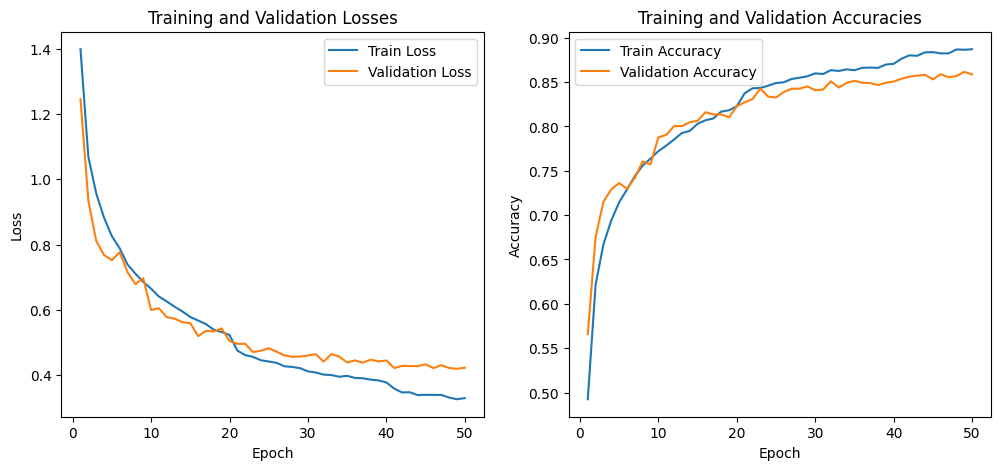

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Define the CNN model for CIFAR-10 with BatchNorm and Dropout
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Feature extractor using Sequential
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: (3, 32, 32) -> Output: (32, 32, 32)
            nn.BatchNorm2d(32),  # Batch Normalization for stabilizing training
            nn.MaxPool2d(2, 2),                         # Output: (32, 16, 16)
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: (64, 16, 16)
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.MaxPool2d(2, 2),                         # Output: (64, 8, 8)
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Output: (128, 8, 8)
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.MaxPool2d(2, 2),                         # Output: (128, 4, 4)
            nn.ReLU(),
        )

        # Classifier using Sequential with Dropout
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),  # Fully connected layer 1
            nn.BatchNorm1d(512),  # Batch Normalization
            nn.Dropout(0.5),  # Dropout for regularization
            nn.ReLU(),

            nn.Linear(512, 256),  # Fully connected layer 2
            nn.BatchNorm1d(256),  # Batch Normalization
            nn.Dropout(0.5),  # Dropout for regularization
            nn.ReLU(),

            nn.Linear(256, 10)  # Output layer for 10 classes (CIFAR-10)
        )

    def featurize(self, x):
        # Extract feature maps
        return self.feature_extractor(x)

    def forward(self, x):
        # Extract features
        features = self.featurize(x)
        # Flatten feature maps for the classifier
        flattened = torch.flatten(features, 1)
        # Pass through the classifier
        output = self.classifier(flattened)
        return output


# Data augmentation and normalization for CIFAR-10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop and pad images
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))  # CIFAR-10 normalization
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Instantiate the model
model = SimpleCNN().to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Reduces lr by a factor of 0.5 every 20 epochs


# Function to calculate accuracy
def accuracy(outputs, targets):
    _, predictions = torch.max(outputs, 1)
    correct = (predictions == targets).sum().item()
    return correct / targets.size(0)


# Training loop
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)


# Validation loop
def validate(model, dataloader, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)


# Train the model
n_epochs = 50
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = validate(model, test_dataloader, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    scheduler.step()  # Step the learning rate scheduler

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

# Plot losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.show()
